In [1]:
import sys, os
sys.path.append("../../")

import pandas as pd

from utils.contract_utils import init_contract
from utils.network_utils import configure_network

from brownie.network import connect, accounts, chain
from brownie_tokens import MintableForkToken
from brownie.exceptions import VirtualMachineError

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)
connect('mainnet-fork')


Launching 'ganache-cli --port 8545 --gasLimit 12000000 --accounts 10 --hardfork istanbul --mnemonic brownie --fork https://eth-mainnet.alchemyapi.io/v2/AxU0de70ONfvbD-3_pQX0wUlaBK6g3G4 --chainId 1'...


In [4]:
pool_contract_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"  # cvxcrv pool addr
pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_contract.name()

'Curve.fi Factory USD Metapool: Magic Internet Money 3Pool'

In [5]:
pool_coin_addrs = []
for i in range(10):
    try:
        pool_coin_addrs.append(pool_contract.coins(i))
    except:
        break
pool_coin_addrs

['0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3',
 '0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490']

In [6]:
pool_balances = pool_contract.get_balances()
print(pool_balances[0] * 1e-18, pool_balances[1] * 1e-18)

638376568.8391343 44904318.279429294


In [7]:
total_coins = (pool_balances[1]+pool_balances[0])
print(f"coin 0 percentage: {pool_balances[0]/total_coins * 100}")
print(f"coin 1 percentage: {pool_balances[1]/total_coins * 100}")

coin 0 percentage: 93.42813195481092
coin 1 percentage: 6.571868045189072


In [8]:
token_1 = init_contract(contract_addr=pool_coin_addrs[1])

In [9]:
amount = 10 * 1E5 * 1e18  # amount per swap
token_0 = MintableForkToken(pool_coin_addrs[0])  # mim
min_amount_received = int(0.5 * amount)

mint_token_0_amount = 500 * 1E6
# mint a lot of token_0: the one which we want to swap into the pool to cause a depeg
token_0._mint_for_testing(accounts[0], mint_token_0_amount * 1E18)

Transaction sent: 0xcb24cbac6e745e3937fdeb59bd5c810c0a1600f133f6d779a655e4245660ba9d
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 1
  MagicInternetMoneyV1.transfer confirmed   Block: 14097966   Gas used: 50951 (0.42%)



In [10]:
# approve large amount of money
token_0.approve(pool_contract_addr, amount * 1e18, {"from": accounts[0]})

Transaction sent: 0x9aa60ee786031051f7e32da29d1f91bc23db6ef7e935964f6c4a4dec288d0da7
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 2
  MagicInternetMoneyV1.approve confirmed   Block: 14097967   Gas used: 44171 (0.37%)



<Transaction '0x9aa60ee786031051f7e32da29d1f91bc23db6ef7e935964f6c4a4dec288d0da7'>

In [11]:
swap_data = []

In [12]:
pool_depeg_slippage = 20
attempts_left = int(mint_token_0_amount / amount)
received_token_1 = 0
while True:

    pool_balances = pool_contract.get_balances()
    swapped_in = amount * 1e-18
    try:
        _tx = pool_contract.exchange(0, 1, amount, min_amount_received, {"from": accounts[0]})
        received_token_1 = _tx.return_value * 1e-18
    except VirtualMachineError:
        break

    slippage = (received_token_1 - swapped_in) / swapped_in * 100

    swap_data.append(
        {
            "pool_balance_token_0": pool_balances[0] * 1e-18,
            "pool_balance_token_1": pool_balances[1] * 1e-18,
            "swapped_in_token_0": swapped_in,
            "received_token_1": received_token_1,
            "slippage": slippage
        }
    )

    print(f"swapped in: {swapped_in}, received: {received_token_1}, slippage: {slippage}")

    if slippage > pool_depeg_slippage:
        break

    attempts_left -= 1
    if attempts_left == 0:
        break

Transaction sent: 0x5eb3f6b12375797b610f839fcd273117b987af59681fb3bfa23ca051e2a42c56
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 3
  Vyper_contract.exchange confirmed   Block: 14097968   Gas used: 160544 (1.34%)

swapped in: 1000000.0, received: 966165.4607522425, slippage: -3.383453924775752
Transaction sent: 0x75df6ffbd0ab0ae23369f2c1c6c37893a488f193a36a0deb1758bcc0d4340814
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 4
  Vyper_contract.exchange confirmed   Block: 14097969   Gas used: 138944 (1.16%)

swapped in: 1000000.0, received: 965557.9346211071, slippage: -3.444206537889293
Transaction sent: 0x49f6cf401f0363801fec42a98ab9ba42d8a8a5f3b2add26dabe98e594b2e3462
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 5
  Vyper_contract.exchange confirmed   Block: 14097970   Gas used: 138944 (1.16%)

swapped in: 1000000.0, received: 964909.829881001, slippage: -3.5090170118998967
Transaction sent: 0x6de649b4cd3d0e7dcd9448cd1e0c5659fa49d52297cccc789e97d31059a01f8f
  Gas 

In [13]:
df_swap_data = pd.DataFrame(swap_data)
df_swap_data

,pool_balance_token_0,pool_balance_token_1,swapped_in_token_0,received_token_1,slippage
0,6.383766e+08,4.490432e+07,1000000.0,966165.460752,-3.383454
1,6.393766e+08,4.393796e+07,1000000.0,965557.934621,-3.444207
2,6.403766e+08,4.297221e+07,1000000.0,964909.829881,-3.509017
3,6.413766e+08,4.200711e+07,1000000.0,964217.512004,-3.578249
4,6.423766e+08,4.104270e+07,1000000.0,963476.938037,-3.652306
5,6.433766e+08,4.007903e+07,1000000.0,962683.601448,-3.731640
6,6.443766e+08,3.911615e+07,1000000.0,961832.468293,-3.816753
7,6.453766e+08,3.815412e+07,1000000.0,960917.903160,-3.908210
8,6.463766e+08,3.719301e+07,1000000.0,959933.583031,-4.006642
9,6.473766e+08,3.623289e+07,1000000.0,958872.396838,-4.112760


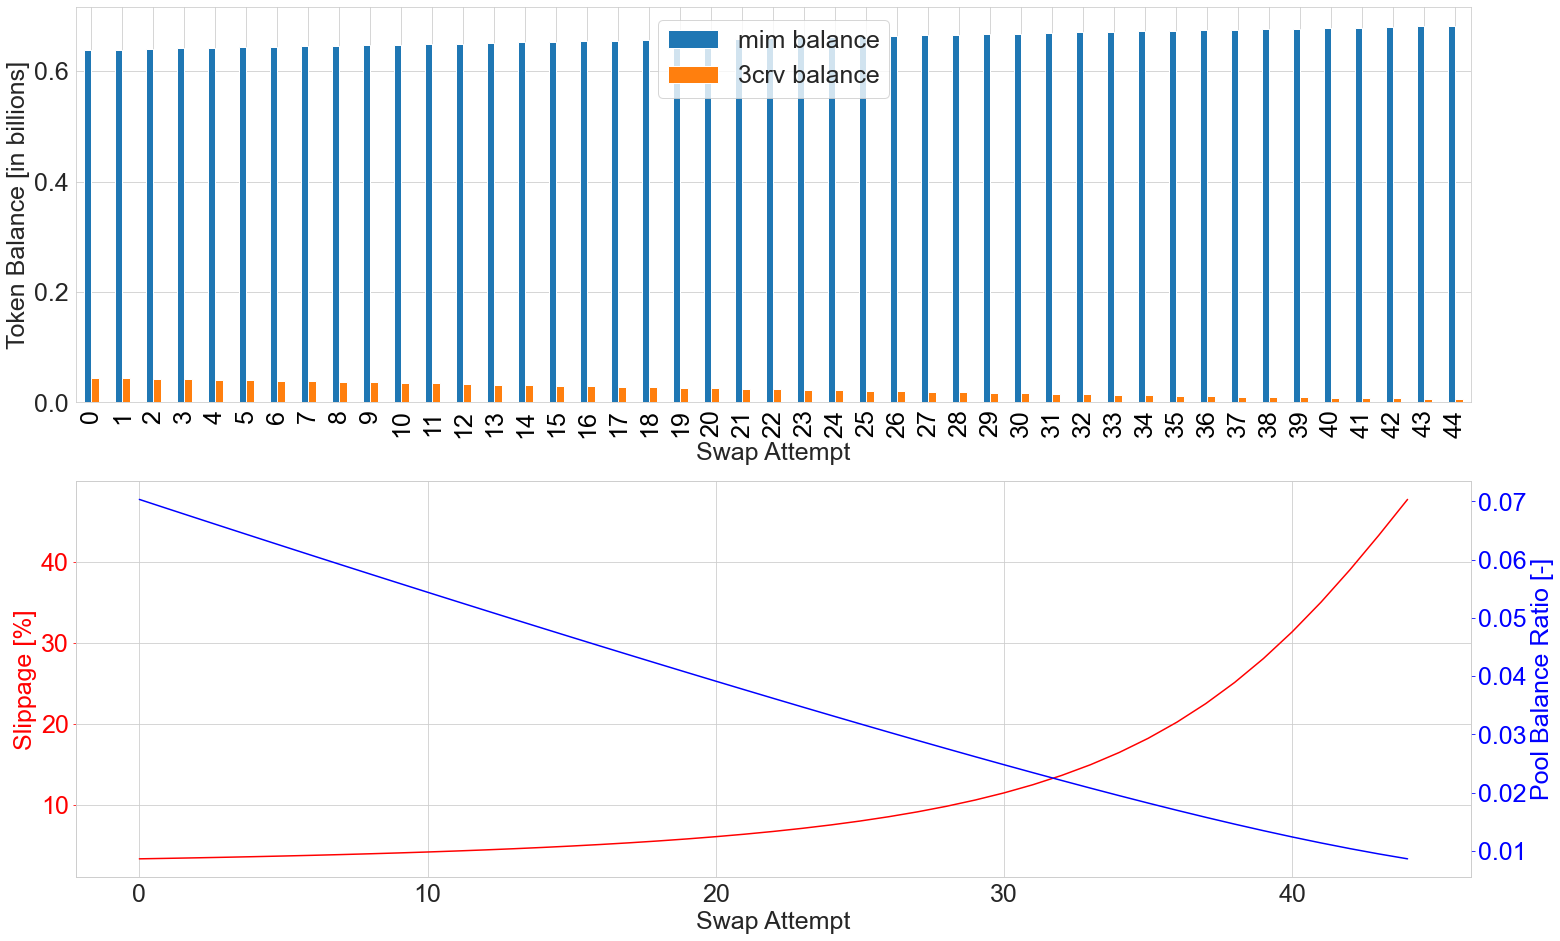

In [22]:
fig, axes = plt.subplots(2,1, figsize=(25, 16))

ax = axes[0]
(df_swap_data[['pool_balance_token_0', 'pool_balance_token_1']] * 1e-9).plot(
    ax=ax,
    kind='bar',
    stacked=False
)

ax.set_xlabel("Swap Attempt", fontsize=25)
ax.set_ylabel("Token Balance [in billions]", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(['mim balance', '3crv balance'], fontsize=25, loc=0)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

ax = axes[1]
ax.plot(
    df_swap_data.index,
    abs(df_swap_data.slippage),
    color='red',
    label='abs slippage'
)
ax.set_xlabel("Swap Attempt", fontsize=25)
ax.set_ylabel("Slippage [%]", fontsize=25, color='red')
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='y', which='major', colors='red')

ax2 = ax.twinx()
ax2.plot(
    df_swap_data.index,
    df_swap_data.pool_balance_token_1/df_swap_data.pool_balance_token_0,
    color='blue',
    label='tokens balance ratio (3crv / mim)'
)
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylabel("Pool Balance Ratio [-]", fontsize=25, color='blue')
ax2.tick_params(axis='y', which='major', colors='blue', labelsize=25)
ax2.grid(False);